✅ Copy each .tif RGB image from rgb_dir to /home/paster/LMY/data/general/images

✅ Convert the corresponding .geojson into a binary mask (.png) and save it to /home/paster/LMY/data/general/mask

In [1]:
import os
import shutil
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import rasterize
from PIL import Image
from tqdm import tqdm

# Input paths
rgb_dir = "/home/paster/LMY/AOI_3_Paris_Train/RGB-PanSharpen"
geojson_dir = "/home/paster/LMY/AOI_3_Paris_Train/geojson/buildings"

# Output paths
out_image_dir = "/home/paster/LMY/data/general/images"
out_mask_dir = "/home/paster/LMY/data/general/mask"

# Create output folders if they don't exist
os.makedirs(out_image_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)

# Process files
for fname in tqdm(os.listdir(rgb_dir)):
    if not fname.endswith(".tif"):
        continue

    img_id = fname.replace("RGB-PanSharpen_", "").replace(".tif", "")
    geojson_path = os.path.join(geojson_dir, f"buildings_{img_id}.geojson")
    tiff_path = os.path.join(rgb_dir, fname)
    out_img_path = os.path.join(out_image_dir, fname)
    out_mask_path = os.path.join(out_mask_dir, f"{img_id}.png")

    # Copy TIFF image
    shutil.copy(tiff_path, out_img_path)

    # Check if geojson exists
    if not os.path.exists(geojson_path):
        print(f"Missing GeoJSON for {img_id}, skipping mask.")
        continue

    # Create PNG mask
    try:
        with rasterio.open(tiff_path) as src:
            transform = src.transform
            shape = src.shape
            crs = src.crs

        gdf = gpd.read_file(geojson_path).to_crs(crs)
        geometries = [(geom, 1) for geom in gdf.geometry if geom.is_valid]

        mask = rasterize(
            geometries,
            out_shape=shape,
            transform=transform,
            fill=0,
            dtype=np.uint8
        )

        Image.fromarray(mask).save(out_mask_path)

    except Exception as e:
        print(f"Error processing {img_id}: {e}")


100%|██████████| 1148/1148 [00:28<00:00, 39.85it/s]


Select 10 TIFF images that have buildings (i.e., GeoJSON contains at least 1 polygon)
Show them in a 3-column subplot:

✅ RGB image

✅ RGB image + mask overlay

✅ Mask alone (binary)

Finds 10 images that have non-empty masks.

Loads the corresponding TIFF RGB image.

Loads the PNG mask.

Normalizes the RGB image.

Visualizes a 3-column subplot per image:

RGB image

Mask

Overlay (RGB + mask)

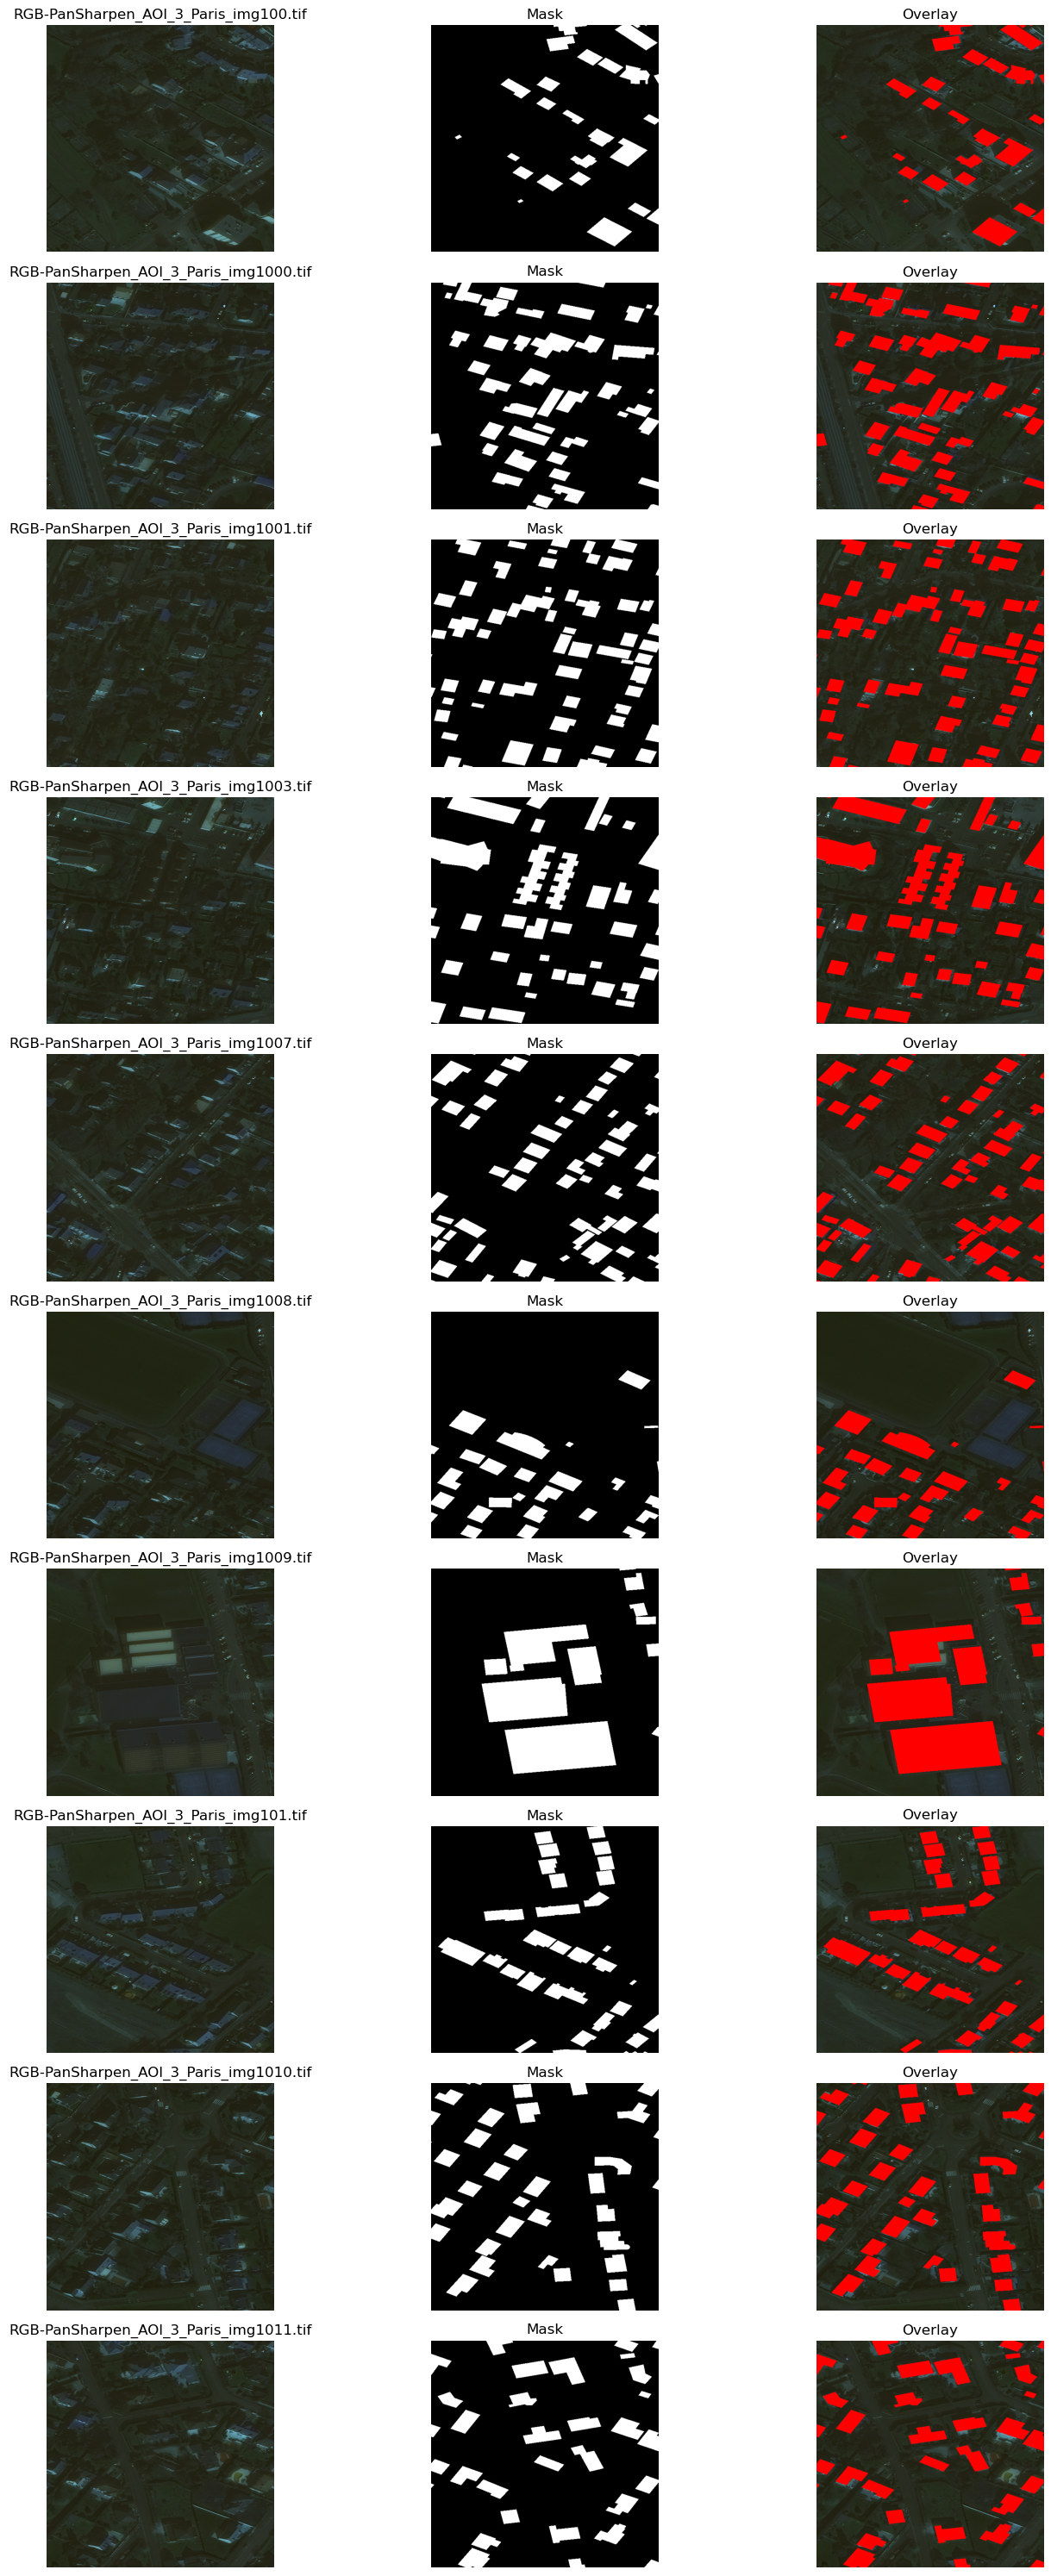

In [2]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from rasterio.plot import reshape_as_image

# Paths
image_dir = "/home/paster/LMY/data/general/images"
mask_dir = "/home/paster/LMY/data/general/mask"

# Get matching image-mask pairs
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
samples = []

for f in image_files:
    img_id = f.replace("RGB-PanSharpen_", "").replace(".tif", "")
    mask_path = os.path.join(mask_dir, f"{img_id}.png")
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None and np.sum(mask) > 0:
            samples.append((os.path.join(image_dir, f), mask_path))
        if len(samples) == 10:
            break

# Visualize
fig, axs = plt.subplots(len(samples), 3, figsize=(15, 3 * len(samples)))

for i, (img_path, mask_path) in enumerate(samples):
    with rasterio.open(img_path) as src:
        rgb = src.read([3, 2, 1])  # Read R, G, B bands
        rgb = reshape_as_image(rgb)
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)  # Normalize

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    overlay = rgb.copy()
    overlay[mask > 0] = [1, 0, 0]  # Red overlay for buildings

    axs[i, 0].imshow(rgb)
    axs[i, 0].set_title(os.path.basename(img_path))
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].set_title("Mask")
    axs[i, 2].imshow(overlay)
    axs[i, 2].set_title("Overlay")

    for j in range(3):
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()


visualize augmentations

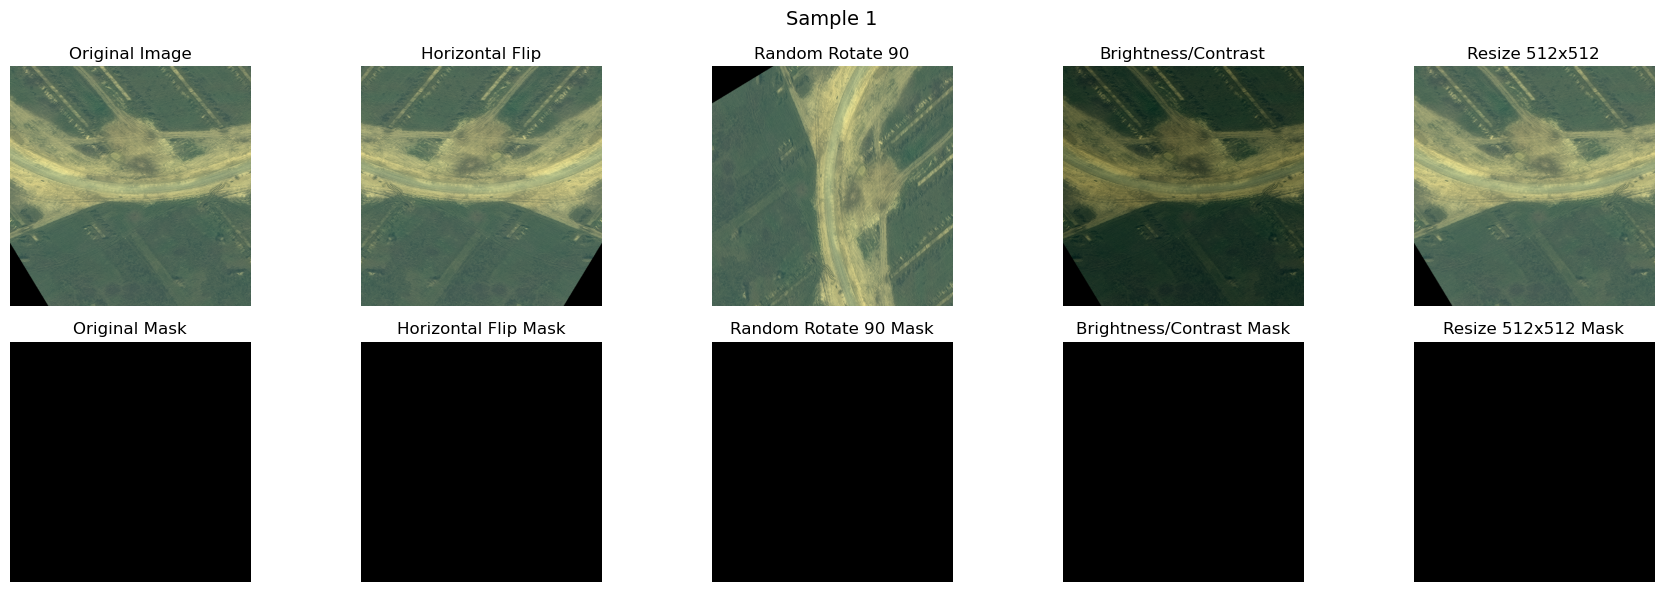

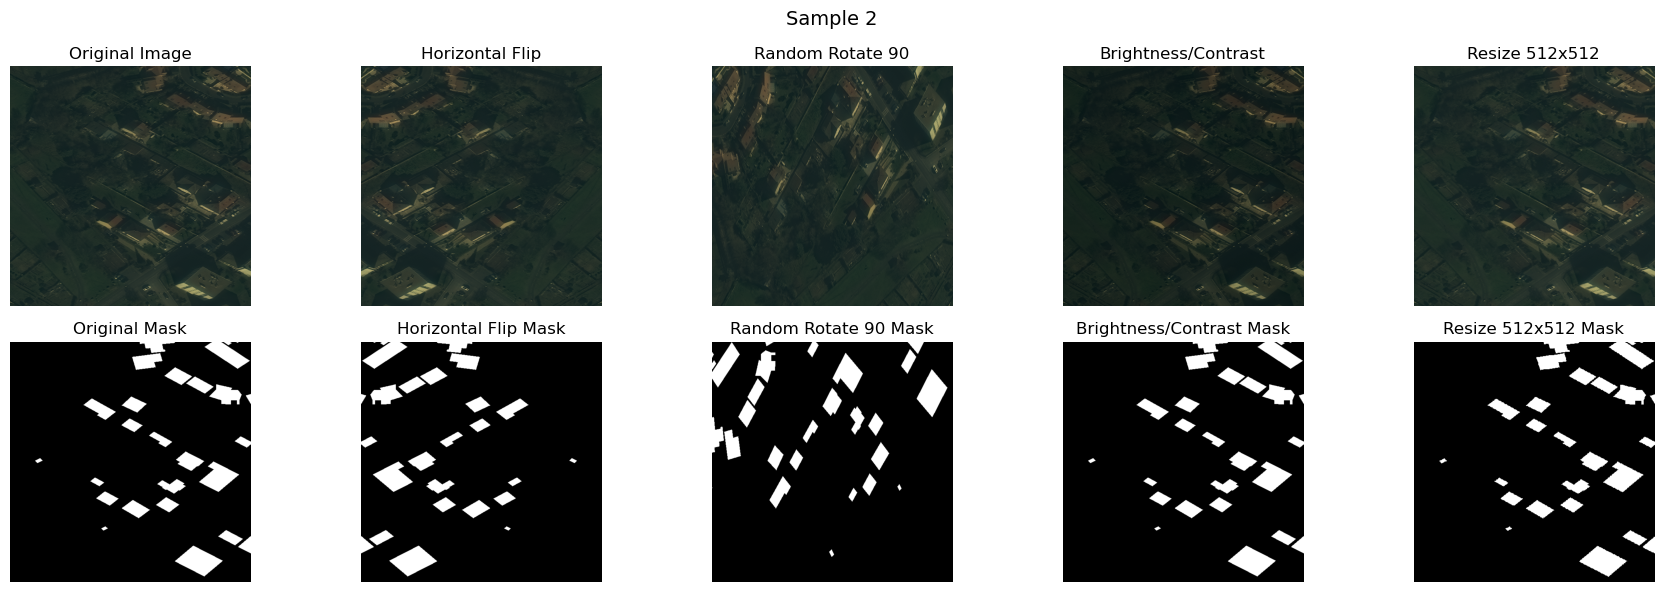

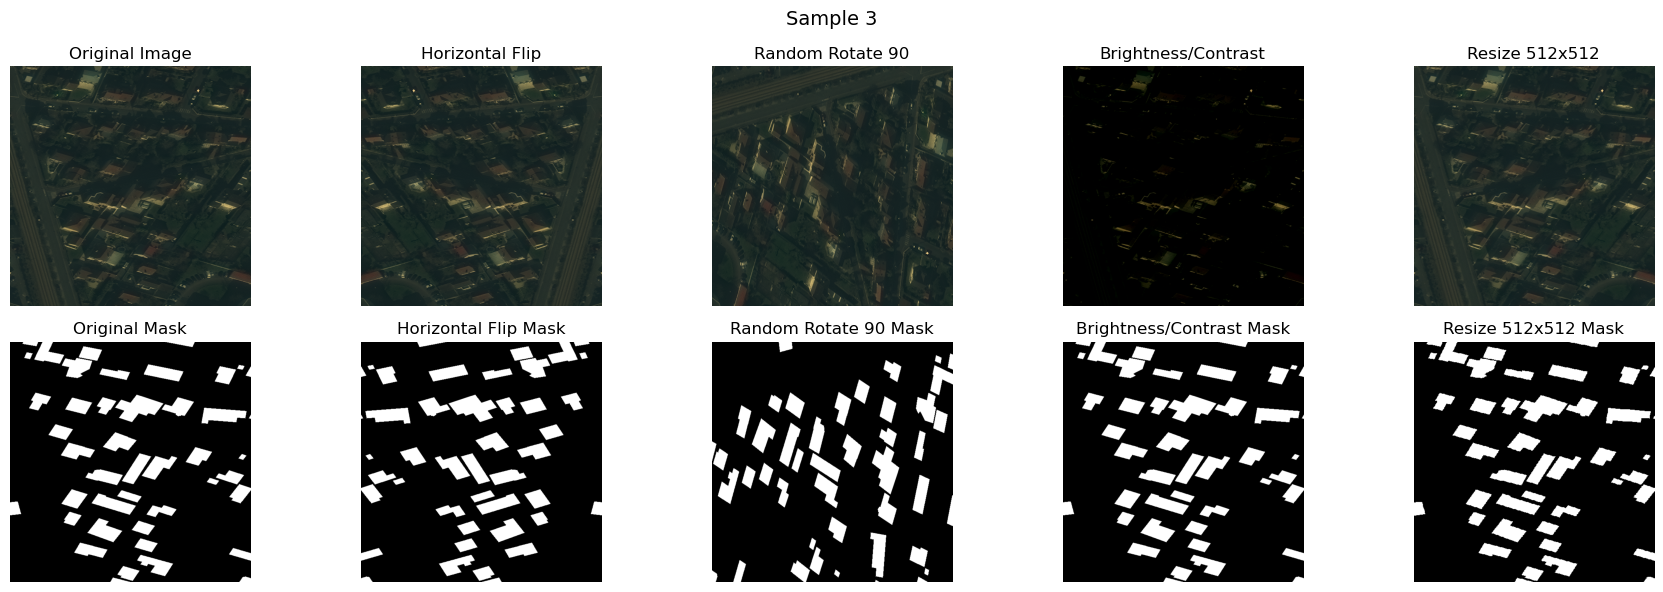

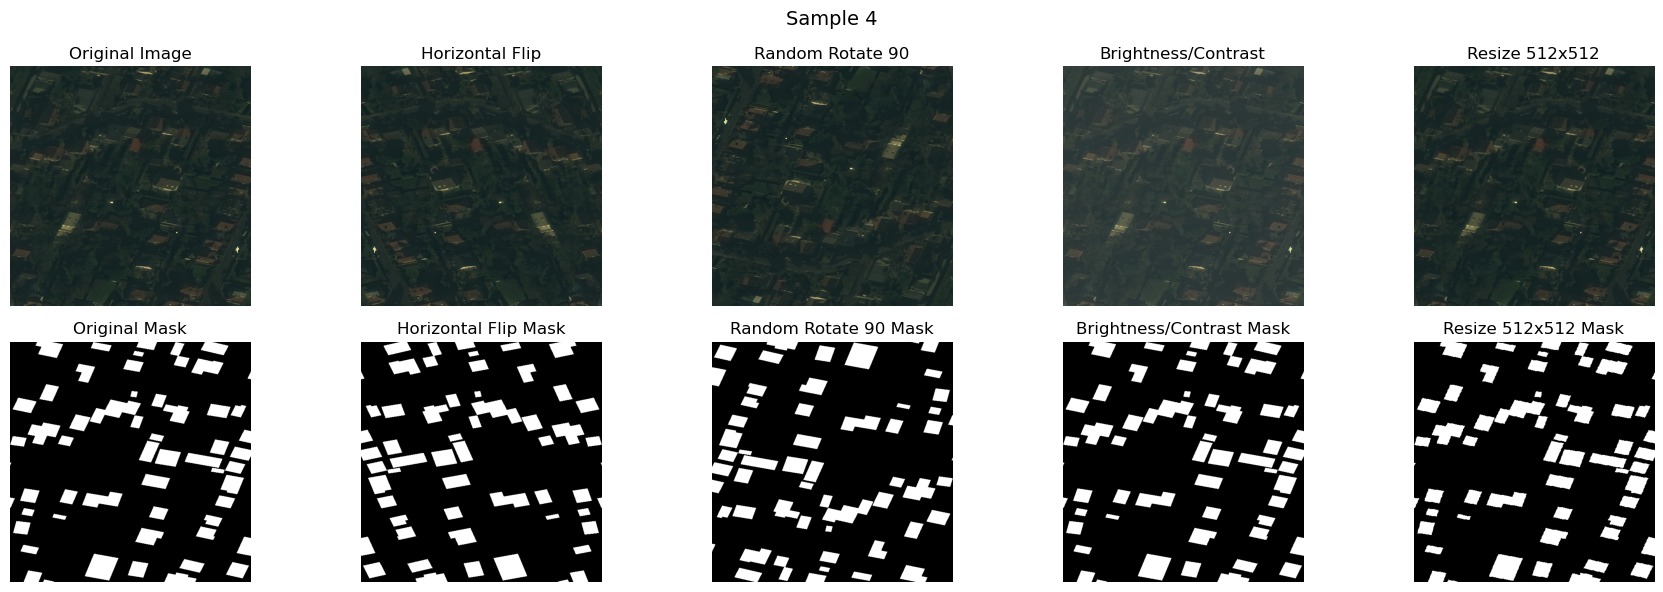

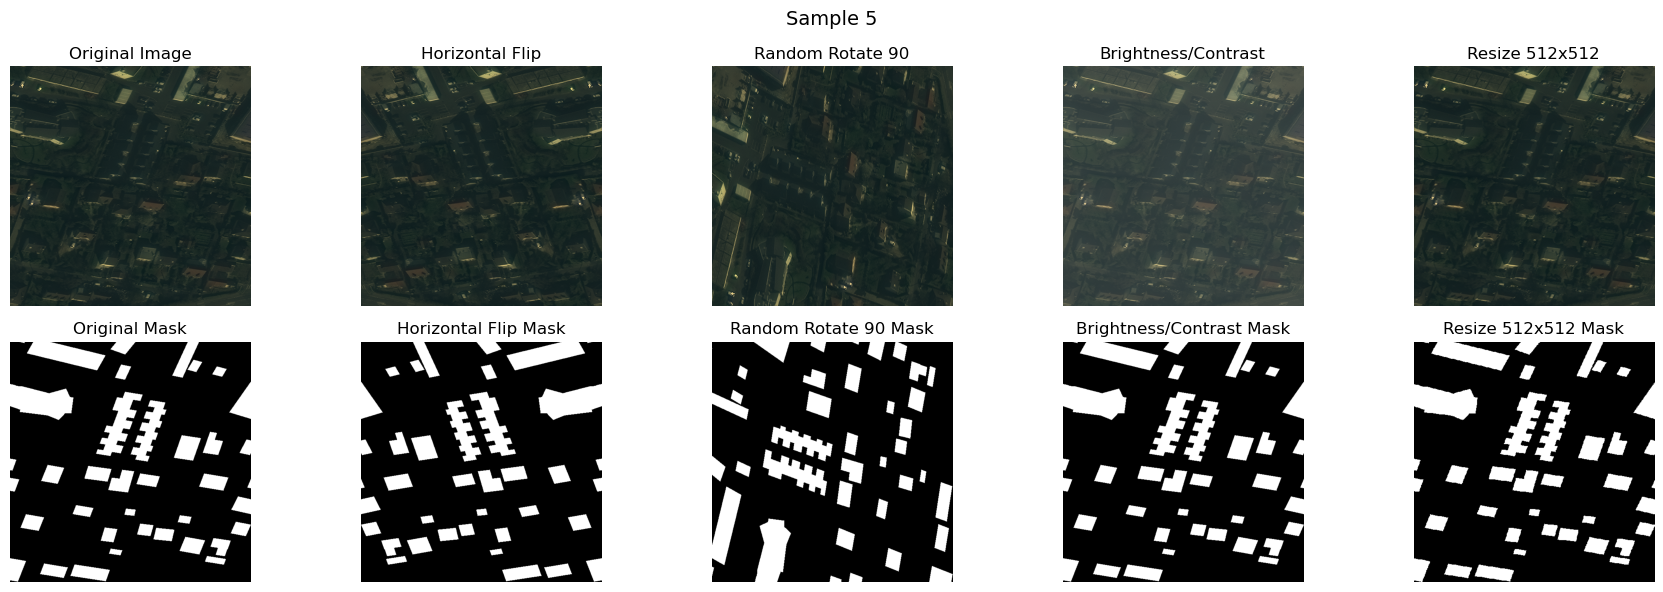

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import rasterio

# Define paths
img_dir = "/home/paster/LMY/data/general/images"
mask_dir = "/home/paster/LMY/data/general/mask"

# Define transformations
transformations = [
    ("Horizontal Flip", A.HorizontalFlip(p=1.0)),
    ("Random Rotate 90", A.RandomRotate90(p=1.0)),
    ("Brightness/Contrast", A.RandomBrightnessContrast(p=1.0)),
    ("Resize 512x512", A.Resize(512, 512))
]

# Select 5 samples with corresponding masks
samples = []
for fname in sorted(os.listdir(img_dir)):
    if fname.endswith(".tif"):
        img_path = os.path.join(img_dir, fname)
        mask_name = fname.replace("RGB-PanSharpen_", "").replace(".tif", ".png")
        mask_path = os.path.join(mask_dir, mask_name)
        if os.path.exists(mask_path):
            samples.append((img_path, mask_path))
        if len(samples) == 5:
            break

# Visualize each sample in separate subplot
for idx, (img_path, mask_path) in enumerate(samples):
    with rasterio.open(img_path) as src:
        image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fig, axs = plt.subplots(2, len(transformations)+1, figsize=(18, 6))
    fig.suptitle(f"Sample {idx+1}", fontsize=14)

    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    axs[1, 0].imshow(mask, cmap="gray")
    axs[1, 0].set_title("Original Mask")
    axs[1, 0].axis("off")

    for i, (name, aug) in enumerate(transformations):
        augmented = aug(image=image, mask=mask)
        aug_img = augmented["image"]
        aug_mask = augmented["mask"]

        axs[0, i+1].imshow(aug_img)
        axs[0, i+1].set_title(name)
        axs[0, i+1].axis("off")

        axs[1, i+1].imshow(aug_mask, cmap="gray")
        axs[1, i+1].set_title(f"{name} Mask")
        axs[1, i+1].axis("off")

    plt.tight_layout()
    plt.show()


split train/valid/test 80/10/10

In [1]:
import os
import shutil
import random
from pathlib import Path

# Local paths
base_image_dir = Path("/home/paster/LMY/data/general/images")
base_mask_dir = Path("/home/paster/LMY/data/general/mask")
output_dir = Path("/home/paster/LMY/data/general/split")

# Create output directories
splits = ["train", "val", "test"]
for split in splits:
    (output_dir / split / "images").mkdir(parents=True, exist_ok=True)
    (output_dir / split / "mask").mkdir(parents=True, exist_ok=True)

# Gather matching image-mask pairs
image_files = sorted(base_image_dir.glob("*.tif"))
valid_pairs = []
for img in image_files:
    mask_name = img.name.replace("RGB-PanSharpen_", "").replace(".tif", ".png")
    mask = base_mask_dir / mask_name
    if mask.exists():
        valid_pairs.append((img, mask))

# Split into train/val/test
random.seed(42)
random.shuffle(valid_pairs)
n = len(valid_pairs)
n_train = int(0.8 * n)
n_val = int(0.10 * n)

train, val, test = valid_pairs[:n_train], valid_pairs[n_train:n_train + n_val], valid_pairs[n_train + n_val:]

# Copy files to respective folders
def copy_to_split(pairs, split):
    for img, msk in pairs:
        img_target = output_dir / split / "images" / img.name
        msk_target_name = img.name.replace(".tif", ".png")
        msk_target = output_dir / split / "mask" / msk_target_name
        shutil.copy(img, img_target)
        shutil.copy(msk, msk_target)

copy_to_split(train, "train")
copy_to_split(val, "val")
copy_to_split(test, "test")

print("✅ Split completed!")
print(f"Train: {len(train)} images")
print(f"Val:   {len(val)} images")
print(f"Test:  {len(test)} images")


✅ Split completed!
Train: 918 images
Val:   114 images
Test:  116 images


visualize tree

In [2]:
import os

def print_tree(startpath, max_depth=2):
    for root, dirs, files in os.walk(startpath):
        depth = root[len(startpath):].count(os.sep)
        if depth > max_depth:
            continue
        indent = " " * 4 * depth
        print(f"{indent}{os.path.basename(root)}/")
        subindent = " " * 4 * (depth + 1)
        for f in sorted(files):
            print(f"{subindent}{f}")

print_tree("/home/paster/LMY/data/general/split")


split/
    train/
        images/
            RGB-PanSharpen_AOI_3_Paris_img100.tif
            RGB-PanSharpen_AOI_3_Paris_img1000.tif
            RGB-PanSharpen_AOI_3_Paris_img1001.tif
            RGB-PanSharpen_AOI_3_Paris_img1003.tif
            RGB-PanSharpen_AOI_3_Paris_img1007.tif
            RGB-PanSharpen_AOI_3_Paris_img101.tif
            RGB-PanSharpen_AOI_3_Paris_img1010.tif
            RGB-PanSharpen_AOI_3_Paris_img1011.tif
            RGB-PanSharpen_AOI_3_Paris_img1012.tif
            RGB-PanSharpen_AOI_3_Paris_img1013.tif
            RGB-PanSharpen_AOI_3_Paris_img1017.tif
            RGB-PanSharpen_AOI_3_Paris_img1018.tif
            RGB-PanSharpen_AOI_3_Paris_img1019.tif
            RGB-PanSharpen_AOI_3_Paris_img102.tif
            RGB-PanSharpen_AOI_3_Paris_img1020.tif
            RGB-PanSharpen_AOI_3_Paris_img1022.tif
            RGB-PanSharpen_AOI_3_Paris_img1026.tif
            RGB-PanSharpen_AOI_3_Paris_img1028.tif
            RGB-PanSharpen_AOI_3_Paris_img1029.tif


✅ Traverse each of train, val, and test folders
✅ Check that:

Every .tif image in images/ has a matching .png mask in mask/

The base name logic is correct (e.g., RGB-PanSharpen_AOI_3_Paris_img123.tif ↔ AOI_3_Paris_img123.png)

In [2]:
import os
from pathlib import Path

base_dir = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]

def check_consistency(split):
    image_dir = base_dir / split / "images"
    mask_dir = base_dir / split / "mask"

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

    image_ids = [f.replace(".tif", "") for f in image_files]
    mask_ids = [f.replace(".png", "") for f in mask_files]

    image_set = set(image_ids)
    mask_set = set(mask_ids)

    only_images = image_set - mask_set
    only_masks = mask_set - image_set
    matched = image_set & mask_set

    print(f"\n📁 Checking '{split}':")
    print(f" - Total images: {len(image_ids)}")
    print(f" - Total masks:  {len(mask_ids)}")
    print(f" - ✅ Matched pairs: {len(matched)}")
    
    if only_images:
        print(f" - ⚠️ Missing masks for: {sorted(list(only_images))}")
    if only_masks:
        print(f" - ⚠️ Orphan masks without images: {sorted(list(only_masks))}")

for split in splits:
    check_consistency(split)



📁 Checking 'train':
 - Total images: 918
 - Total masks:  918
 - ✅ Matched pairs: 918

📁 Checking 'val':
 - Total images: 114
 - Total masks:  114
 - ✅ Matched pairs: 114

📁 Checking 'test':
 - Total images: 116
 - Total masks:  116
 - ✅ Matched pairs: 116


distribution of building count and area

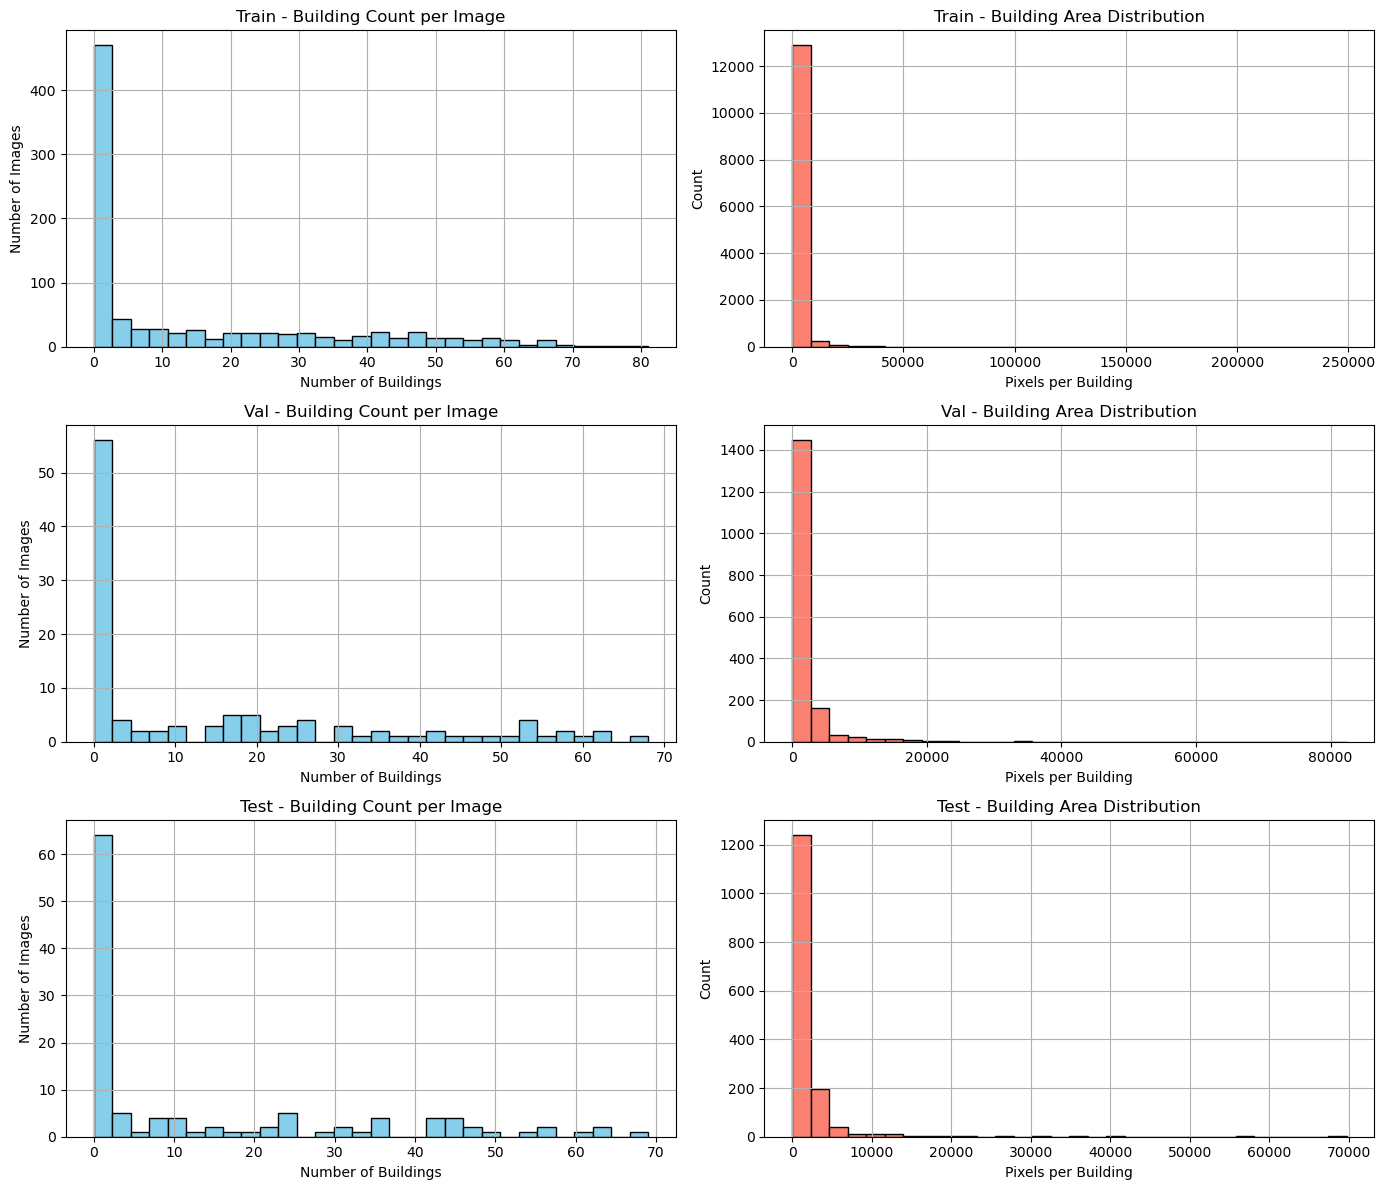

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Directories
split_base = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]

# Collect data
split_stats = {}

for split in splits:
    mask_dir = split_base / split / "mask"
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])
    
    building_counts = []
    building_areas = []

    for fname in mask_files:
        mask_path = mask_dir / fname
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if mask is None:
            continue

        # Count number of separate buildings (connected components)
        num_buildings, labels = cv2.connectedComponents(mask, connectivity=4)

        # Skip background (label 0)
        building_counts.append(num_buildings - 1)
        building_areas.extend([np.sum(labels == i) for i in range(1, num_buildings)])

    split_stats[split] = {
        "counts": building_counts,
        "areas": building_areas,
    }

# Plotting
fig, axs = plt.subplots(len(splits), 2, figsize=(14, 12))

for i, split in enumerate(splits):
    axs[i, 0].hist(split_stats[split]["counts"], bins=30, color="skyblue", edgecolor="black")
    axs[i, 0].set_title(f"{split.capitalize()} - Building Count per Image")
    axs[i, 0].set_xlabel("Number of Buildings")
    axs[i, 0].set_ylabel("Number of Images")
    axs[i, 0].grid(True)

    axs[i, 1].hist(split_stats[split]["areas"], bins=30, color="salmon", edgecolor="black")
    axs[i, 1].set_title(f"{split.capitalize()} - Building Area Distribution")
    axs[i, 1].set_xlabel("Pixels per Building")
    axs[i, 1].set_ylabel("Count")
    axs[i, 1].grid(True)

plt.tight_layout()
plt.show()


distribution of zero count nad non zero count building in every train, valid, test

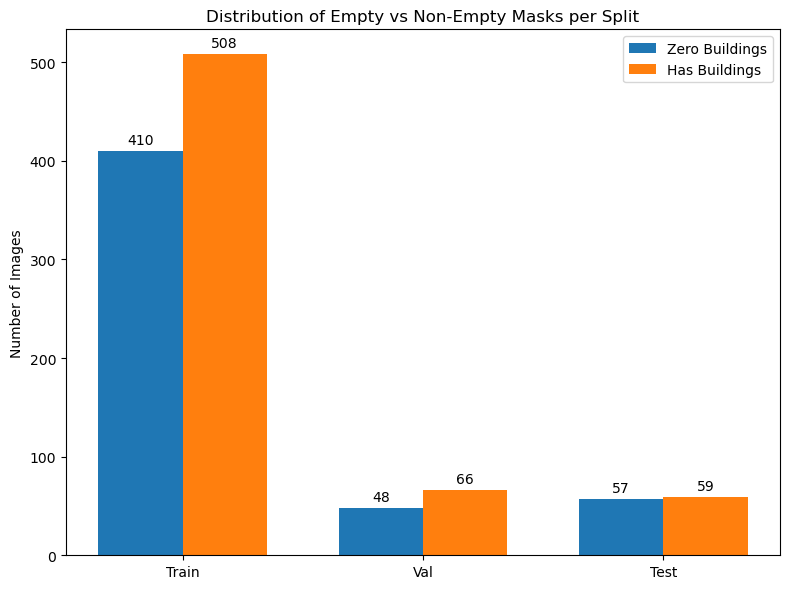

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
split_base = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]

# Result storage
zero_nonzero_counts = {}

for split in splits:
    mask_dir = split_base / split / "mask"
    zero_count = 0
    nonzero_count = 0

    for fname in sorted(mask_dir.glob("*.png")):
        mask = cv2.imread(str(fname), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        if np.sum(mask) == 0:
            zero_count += 1
        else:
            nonzero_count += 1

    zero_nonzero_counts[split] = {
        "zero": zero_count,
        "nonzero": nonzero_count,
    }

# Plot
labels = ["Train", "Val", "Test"]
zero = [zero_nonzero_counts[s]["zero"] for s in splits]
nonzero = [zero_nonzero_counts[s]["nonzero"] for s in splits]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(x - width/2, zero, width, label="Zero Buildings")
bar2 = ax.bar(x + width/2, nonzero, width, label="Has Buildings")

ax.set_ylabel("Number of Images")
ax.set_title("Distribution of Empty vs Non-Empty Masks per Split")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(bar1, padding=3)
ax.bar_label(bar2, padding=3)
plt.tight_layout()
plt.show()


Check if masks are corrupted or unreadable by OpenCV

In [3]:
import cv2
from pathlib import Path

mask_dir = Path("/home/paster/LMY/data/general/split/val/mask")
bad_files = []

for mask_file in sorted(mask_dir.glob("*.png")):
    img = cv2.imread(str(mask_file), cv2.IMREAD_GRAYSCALE)
    if img is None:
        bad_files.append(mask_file.name)

print(f"\n❌ Bad (unreadable) mask files: {len(bad_files)}")
for f in bad_files[:10]:
    print(f)




❌ Bad (unreadable) mask files: 0


Go through all images and masks in /home/paster/LMY/data/general/split/val.

Show a subplot (image, mask) for each non-empty mask.

✅ Found 66 non-empty mask/image pairs


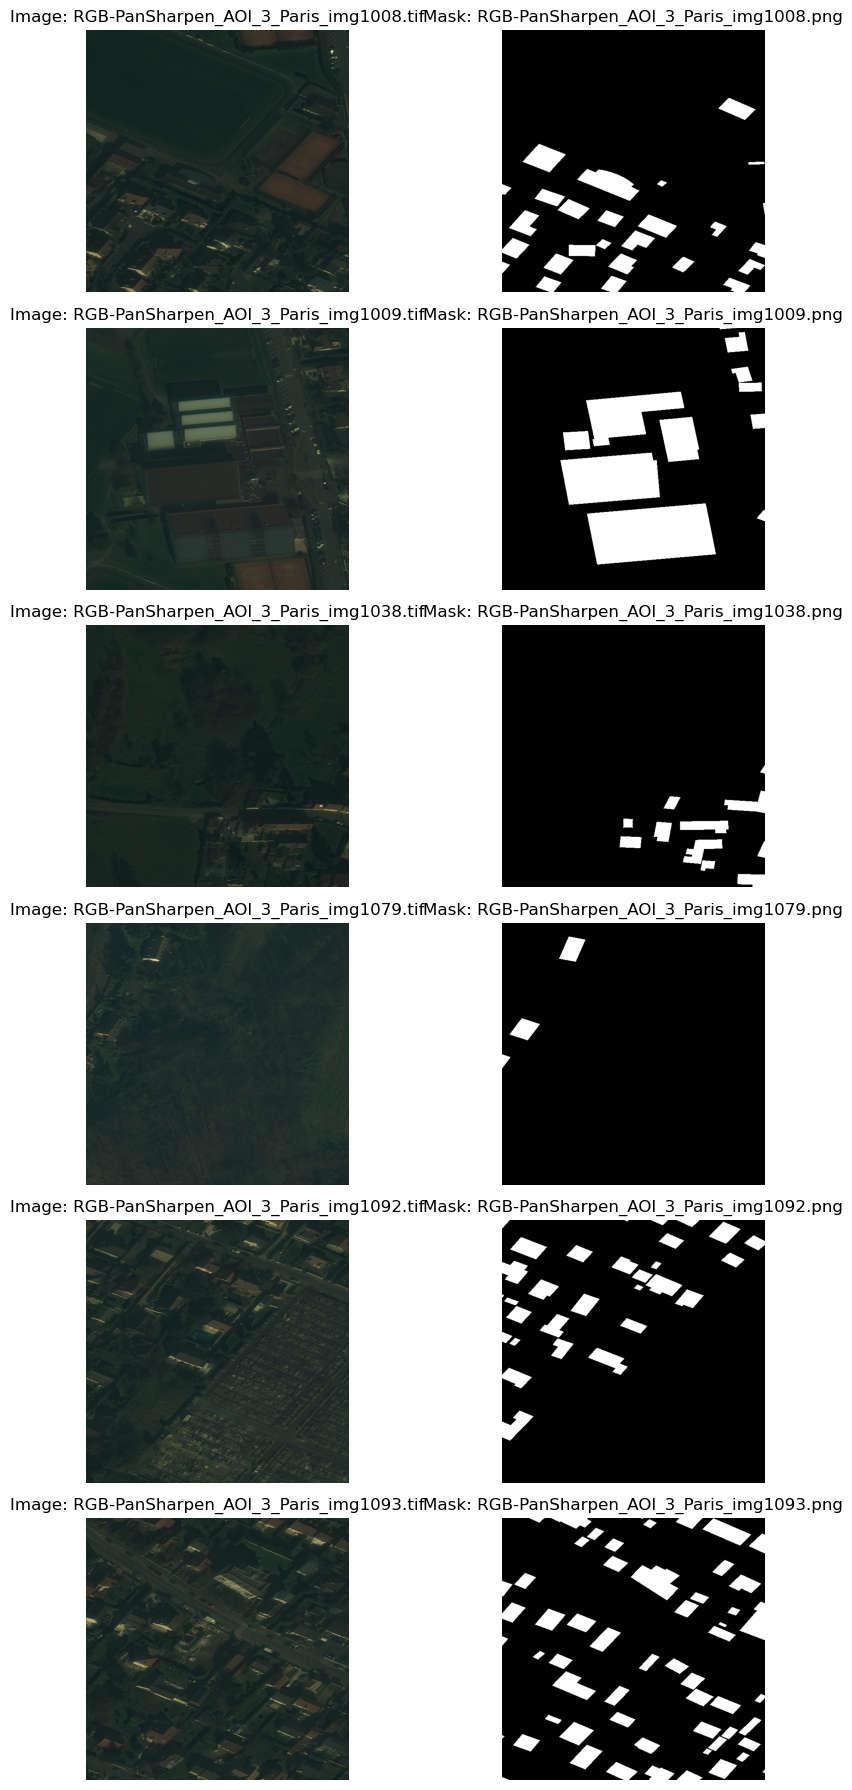

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

base_dir = Path("/home/paster/LMY/data/general/split/val")
image_dir = base_dir / "images"
mask_dir = base_dir / "mask"

pairs = []
for mask_path in sorted(mask_dir.glob("*.png")):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"❌ Cannot read: {mask_path}")
        continue
    if np.sum(mask) > 0:
        image_name = mask_path.name.replace(".png", ".tif")
        image_path = image_dir / image_name
        if image_path.exists():
            pairs.append((image_path, mask_path))
        else:
            print(f"⚠️ No image found for: {mask_path.name}")

print(f"✅ Found {len(pairs)} non-empty mask/image pairs")

if not pairs:
    print("❌ No non-empty masks found.")
else:
    n = min(6, len(pairs))
    fig, axes = plt.subplots(n, 2, figsize=(10, 3 * n))
    
    for i in range(n):
        img_path, mask_path = pairs[i]

        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])  # RGB bands
            image = np.transpose(image, (1, 2, 0))  # CHW → HWC
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Image: {img_path.name}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f"Mask: {mask_path.name}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()



